In [1]:
import time
import pickle
import glob
import json
import pandas as pd
import seaborn as sns
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from matplotlib import rcParams
import matplotlib.pyplot as plt

import os
os.environ['OPENAI_API_KEY'] = 'key'

In [2]:
with open('data_input/scipdf.pkl', 'rb') as handle:
    pdf_dict = pickle.load(handle)
    
pdf_doi_dict = {}
for pdf_name in pdf_dict.keys():
    pdf_doi_dict[pdf_name.replace(".pdf", "")] = pdf_dict[pdf_name]["doi"]

In [ ]:
marker_results = pd.DataFrame()
fail_list = []

for key in pdf_dict.keys():
    time.sleep(2)
    embeddings = OpenAIEmbeddings()
    key = key.replace(".pdf", "")
    db = FAISS.load_local("data_faiss/faiss_chunked/faiss_db_1000/{}".format(key), embeddings, allow_dangerous_deserialization=True)
    retriever = db.as_retriever(search_type="similarity_score_threshold",
                                search_kwargs={"score_threshold": 0.5, "k": 25})

    query = """Find all the names of significant QTLs, QTNs, MTAs, SNPs, SRR regions or GWAS marker names mentioned in the manuscript. \
               For each significant marker you find, find which trait or condition it is associated with, or which trait or condition was \
               used to genetically map to this trait. If there are multiple traits or conditions associated with a single marker, combine them. 

               Important - Respond in JSON format only, following the schema below:
                ```json
                {
                "marker": string  // QTL, QTN, MTA, SNP, SRR regions or GWAS marker name
                "trait_full": string  // full, non-abbreviated, names of all traits associated with the given marker
                "trait_abv": string  // abbreviated names of all traits associated with the given marker
                "chromosome": string // chromosome name and location information, if available. NaN if not found
                "genomic_range": string // range of genomic region the marker was mapped to, if available. NaN if not found
                }
                ```
            """
    
    # Uncommend the LLM model you want to use for the RAG chain
    #llm = ChatOpenAI(model_name='gpt-3.5-turbo-1106')
    llm = ChatOpenAI(model_name='gpt-4') 
    qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever)
    marker_response = qa(query)

    try:
        response_string = marker_response['result']
        response_string = response_string.split("```")[1] if "```" in response_string else response_string
        response_string = response_string.replace("```", "")
        response_string = response_string.replace("json\n", "")
        response_string = response_string.replace("}\n{", "},\n{")
        response_string = response_string.replace("\n}\n}\n", "\n}\n")
        response_string = response_string.replace("}\n", "}")

        if "[" not in response_string:
            response_string = "[" + response_string
        if "]" not in response_string:
            response_string = response_string + "]"

        # Parse the JSON format and turn it into a pandas dataframe
        response_json = json.loads(response_string)
        tmp_df = pd.DataFrame(response_json)

        # Add the PDF and DOI IDs so it is easier to keep track of
        tmp_df["pdf"] = key
        tmp_df["doi"] = pdf_doi_dict[key]
        marker_results = pd.concat([marker_results, tmp_df])
        print("success,"+key)
    except:
        print("fail,"+key)
        fail_list.append([key, marker_response['result']])
marker_results.to_csv("data_output/markers/all_papers_size_1000_25_gpt4.2.tsv".format(key), sep="\t", index=None)

# Short results over all papers

<Axes: xlabel='Model', ylabel='% correct'>

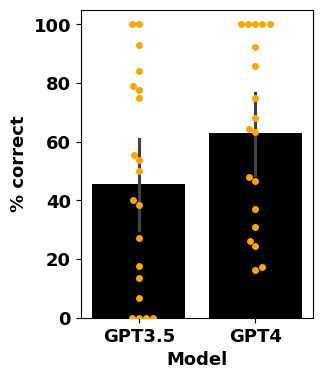

In [3]:
true_markers = pd.read_csv("data_input/markers/EP_final_all_markers_in_papers.txt", sep="\t")
true_markers = true_markers.groupby("doi").count().reset_index()[["doi", "MTA"]]

pred_markers = pd.read_csv("data_output/markers/all_papers_marker_results_processed_GPT3_4.txt", sep="\t")
pred_markers = pred_markers.drop_duplicates(["Model", "doi", "marker"])
pred_markers = pred_markers.groupby(["doi", "Model"]).sum().reset_index()[["Model", "doi", "correct"]]
results = pred_markers.merge(true_markers, on="doi", how="left")

results['% correct'] = results["correct"] / results["MTA"] * 100
results = results[results["doi"]!="10.1007/s10142-018-0630-z"]

plt.rcParams.update({'font.weight': 'bold', 'font.size': 13, 
                     'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
fig, ax = plt.subplots(figsize=(3, 4))

sns.barplot(data=results, x="Model", y= "% correct", color="black")
sns.swarmplot(data=results, x="Model", y= "% correct", color="orange")

# Analyze a single paper with different chunk sizes and K

In [ ]:
marker_results = pd.DataFrame()
fail_list = []
key = "s00122-022-04109-9.pdf"

for size in [250,500,750,1000]:
    for k in [5,10,15,20,25]:
        for rep in [1,2,3,4]:
            time.sleep(2)
            embeddings = OpenAIEmbeddings()
            key = key.replace(".pdf", "")
            db = FAISS.load_local("data_faiss/faiss_chunked/faiss_db_{}/{}".format(size, key), embeddings)
            retriever = db.as_retriever(search_type="similarity_score_threshold",
                                        search_kwargs={"score_threshold": 0.5, "k": k})
            
            query = """Find all the names of significant QTLs, QTNs, MTAs, SNPs, SRR regions or GWAS marker names mentioned in the manuscript. \
                       For each significant marker you find, find which trait or condition it is associated with, or which trait or condition was \
                       used to genetically map to this trait. If there are multiple traits or conditions associated with a single marker, combine them. 

                       Important - Respond in JSON format only, following the schema below:
                        ```json
                        {
                        "marker": string  // QTL, QTN, MTA, SNP, SRR regions or GWAS marker name
                        "trait_full": string  // full, non-abbreviated, names of all traits associated with the given marker
                        "trait_abv": string  // abbreviated names of all traits associated with the given marker
                        "chromosome": string // chromosome name and location information, if available. NaN if not found
                        "genomic_range": string // range of genomic region the marker was mapped to, if available. NaN if not found
                        }
                        ```
                    """

            # Uncommend the LLM model you want to use for the RAG chain
            #llm = ChatOpenAI(model_name='gpt-3.5-turbo-1106')
            llm = ChatOpenAI(model_name='gpt-4') 
            qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever)
            marker_response = qa(query)
            
            # Correct the returned JSON format based on observed errors
            try:
                response_string = marker_response['result']
                response_string = response_string.split("```")[1] if "```" in response_string else response_string
                response_string = response_string.replace("```", "")
                response_string = response_string.replace("json\n", "")
                response_string = response_string.replace("}\n{", "},\n{")
                response_string = response_string.replace("\n}\n}\n", "\n}\n")
                response_string = response_string.replace("}\n", "}")
                
                if "[" not in response_string:
                    response_string = "[" + response_string
                if "]" not in response_string:
                    response_string = response_string + "]"
                
                # Parse the JSON format and turn it into a pandas dataframe
                response_json = json.loads(response_string)
                tmp_df = pd.DataFrame(response_json)
                
                # Add the PDF and DOI IDs so it is easier to keep track of
                tmp_df["pdf"] = key
                tmp_df["doi"] = pdf_doi_dict[key]
                tmp_df["k"] = k
                tmp_df["rep"] = rep
                tmp_df["size"] = size
                marker_results = pd.concat([marker_results, tmp_df])
            except:
                fail_list.append([key, size, k, rep, marker_response['result']])
marker_results.to_csv("data_output/markers/{}_size250-1000_5-25_gpt4.tsv".format(key), sep="\t", index=None)

# Make plots for the different k and chunk size comparisons

In [4]:
manual_markers = pd.read_csv("data_input/markers/manual_markers_selected.txt", sep="\t")
true_markers = manual_markers["qtl"].tolist()
true_markers = pd.read_csv("data_input/markers/EP_final_all_markers_in_papers.txt", sep="\t")
true_markers = true_markers.groupby("doi").count().reset_index()[["doi", "MTA"]]
n_markers = true_markers[true_markers["doi"]=="10.1007/s00122-022-04109-9"]["MTA"].iloc[0]

(0.0, 100.0)

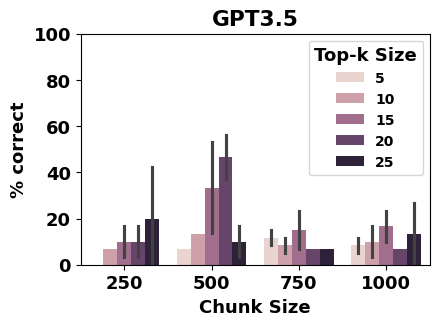

In [5]:
plt.rcParams.update({'font.weight': 'bold', 'font.size': 13, 
                     'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
fig, ax = plt.subplots(figsize=(4.5, 3))

trait_results = pd.read_csv("data_output/markers/s00122-022-04109-9_size250-1000_5-25_gpt3.5.tsv" ,sep="\t")
trait_results = trait_results[trait_results["correct"]==1]
trait_results = trait_results[["k", "rep", "size", "correct"]].groupby(["k", "rep", "size"]).sum().reset_index()
trait_results["% correct"] = trait_results["correct"] / n_markers * 100

trait_results.columns = ["Top-k Size", "rep", "Chunk Size", "correct","% correct"]
ax = sns.barplot(data=trait_results, x="Chunk Size", y="% correct", hue="Top-k Size", errorbar="sd")
ax.set_title("GPT3.5")
plt.legend(loc='upper right', title="Top-k Size", prop={'size': 10})
plt.ylim(0, 100)

(0.0, 100.0)

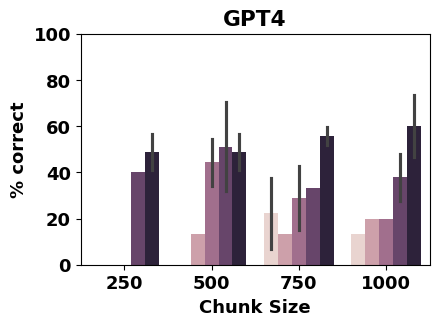

In [6]:
plt.rcParams.update({'font.weight': 'bold', 'font.size': 13, 
                     'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
fig, ax = plt.subplots(figsize=(4.5, 3))

trait_results = pd.read_csv("data_output/markers/s00122-022-04109-9_size250-1000_5-25_gpt4.tsv" ,sep="\t")
trait_results = trait_results[trait_results["correct"]==1]
trait_results = trait_results[["k", "rep", "size", "correct"]].groupby(["k", "rep", "size"]).sum().reset_index()
trait_results["% correct"] = trait_results["correct"] / n_markers * 100

trait_results.columns = ["Top-k Size", "rep", "Chunk Size", "correct","% correct"]
ax = sns.barplot(data=trait_results, x="Chunk Size", y="% correct", hue="Top-k Size", errorbar="sd")
ax.set_title("GPT4")
ax.get_legend().remove()
plt.ylim(0, 100)